# Parameter Inference With Bioscrape

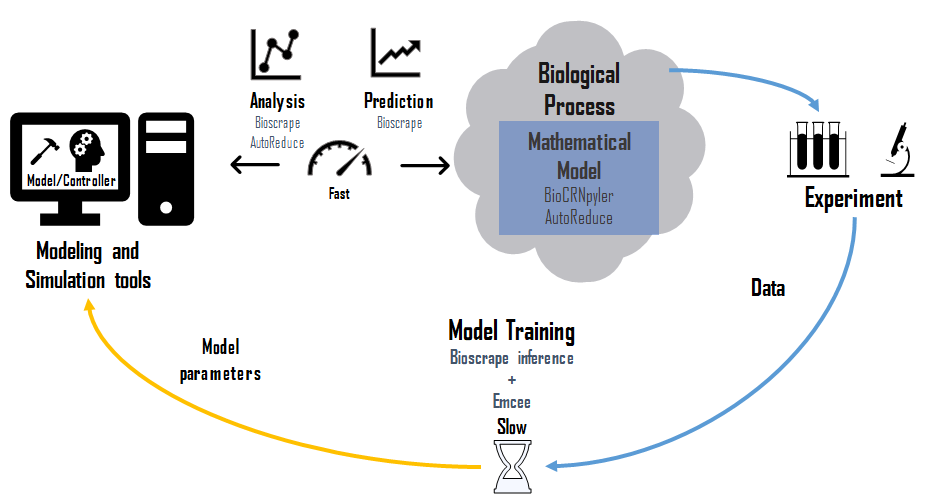

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from cycler import cycler
import numpy as np
import bioscrape as bs

sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})


mpl.rc('axes', prop_cycle=(cycler('color', ['r', 'k', 'b','g','y','m','c']) ))

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
# Use Helvetica, if installed:
# mpl.rcParams['font.family'] = 'Helvetica'

tw = 1.5

sns.set_style({"xtick.major.size": 3, "ytick.major.size": 3,
               "xtick.minor.size": 2, "ytick.minor.size": 2,
               'axes.labelsize': 16, 'axes.titlesize': 16,
               'xtick.major.width': tw, 'xtick.minor.width': tw,
               'ytick.major.width': tw, 'ytick.minor.width': tw})

mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', linewidth=1.5, titlesize=14, labelsize=14)
mpl.rc('legend', fontsize=14)
mpl.rc('figure', figsize=(8.5,15))

## Load data and create dataframe

To get started with parameter identification, we load the data file from Github:

## Pre-process the CSV from Echo or Biotek

In [2]:
import pandas as pd
import numpy as np

def time_in_minutes(t):
    ans = t.hour*60+t.minute+t.second/60.0+t.microsecond / 1000000.0 / 60.0
    if type(t).__name__ == 'datetime':
        ans += t.day * 24*60
    return ans
        
csv_data = pd.read_csv('../experimental_data/20220610_Triplicate_2D_Int_Xis_Dilution_Biotek1_tidy.csv')

# Data arrays:
num_integrase_conditions = 5
num_reporter_conditions = 1
num_xis_conditions = 5
num_replicates = 3
biotek_gain = 100

# All time points are the same, so just get one set of times for a given condition and measurement
chosen_well = np.array(csv_data.loc[(csv_data['Channel'].eq('YFP'))& (csv_data['Int (nM)'].eq(1))\
                       & (csv_data['Xis (nM)'].eq(1))\
                       & (csv_data['Gain'].eq(biotek_gain))]['Well'])[0]
timepoints = np.array(csv_data.loc[(csv_data['Channel'].eq('YFP'))& (csv_data['Int (nM)'].eq(1))\
                       & (csv_data['Xis (nM)'].eq(1))\
                       & (csv_data['Gain'].eq(biotek_gain)) & (csv_data['Well'].eq(chosen_well))]['Time (hr)']*60)
real_timepoints = timepoints

num_timepoints = np.shape(timepoints)[0]
full_cfp = np.empty( (num_timepoints, num_replicates , num_integrase_conditions , num_xis_conditions ) )
back_cfp = np.empty( (num_timepoints, num_replicates , num_integrase_conditions , num_xis_conditions ) )
full_mScar = np.empty( (num_timepoints, num_replicates , num_integrase_conditions , num_xis_conditions ) )
back_mScar = np.empty( (num_timepoints, num_replicates , num_integrase_conditions , num_xis_conditions ) )
full_yfp = np.empty( (num_timepoints, num_replicates , num_integrase_conditions , num_xis_conditions ) )
back_yfp = np.empty( (num_timepoints, num_replicates , num_integrase_conditions , num_xis_conditions ) )

int_conditions = [0, 0.5, 1, 1.5, 2]
xis_conditions = [0, 0.25, 0.5, 0.75, 1]
rep_conditions = [1]
rep_nm = 1
for int_nm,int_ind in zip(int_conditions,range(num_integrase_conditions)):
    for xis_nm,xis_ind in zip(xis_conditions,range(num_xis_conditions)):
        for repl in range(num_replicates):
            replicate = repl+1
            full_cfp[:,repl,int_ind,xis_ind] = np.array(csv_data.loc[(csv_data['Channel'].eq('CFP'))\
                                                                   & (csv_data['Int (nM)'].eq(int_nm))\
                                                                   & (csv_data['Xis (nM)'].eq(xis_nm))\
                                                                   & (csv_data['Rep (nM)'].eq(rep_nm))\
                                                                   & (csv_data['Gain'].eq(biotek_gain))\
                                                                   & (csv_data['Replicate'].eq(replicate))]\
                                                      ['Measurement'])
            back_cfp[:,repl,int_ind,xis_ind] = np.array(csv_data.loc[(csv_data['Channel'].eq('CFP'))\
                                                                   & (csv_data['Int (nM)'].eq(0))\
                                                                   & (csv_data['Xis (nM)'].eq(xis_nm))\
                                                                   & (csv_data['Rep (nM)'].eq(rep_nm))\
                                                                   & (csv_data['Gain'].eq(biotek_gain))\
                                                                   & (csv_data['Replicate'].eq(replicate))]\
                                                      ['Measurement'])
            full_mScar[:,repl,int_ind,xis_ind] = np.array(csv_data.loc[(csv_data['Channel'].eq('mScarlet'))\
                                                                   & (csv_data['Int (nM)'].eq(int_nm))\
                                                                   & (csv_data['Xis (nM)'].eq(xis_nm))\
                                                                   & (csv_data['Rep (nM)'].eq(rep_nm))\
                                                                   & (csv_data['Gain'].eq(biotek_gain))\
                                                                   & (csv_data['Replicate'].eq(replicate))]\
                                                      ['Measurement'])
            back_mScar[:,repl,int_ind,xis_ind] = np.array(csv_data.loc[(csv_data['Channel'].eq('mScarlet'))\
                                                                   & (csv_data['Int (nM)'].eq(int_nm))\
                                                                   & (csv_data['Xis (nM)'].eq(0))\
                                                                   & (csv_data['Rep (nM)'].eq(rep_nm))\
                                                                   & (csv_data['Gain'].eq(biotek_gain))\
                                                                   & (csv_data['Replicate'].eq(replicate))]\
                                                      ['Measurement'])
            full_yfp[:,repl,int_ind,xis_ind] = np.array(csv_data.loc[(csv_data['Channel'].eq('YFP'))\
                                                                   & (csv_data['Int (nM)'].eq(int_nm))\
                                                                   & (csv_data['Xis (nM)'].eq(xis_nm))\
                                                                   & (csv_data['Rep (nM)'].eq(rep_nm))\
                                                                   & (csv_data['Gain'].eq(biotek_gain))\
                                                                   & (csv_data['Replicate'].eq(replicate))]\
                                                      ['Measurement'])
            back_yfp[:,repl,int_ind,xis_ind] = np.array(csv_data.loc[(csv_data['Channel'].eq('YFP'))\
                                                                   & (csv_data['Int (nM)'].eq(0))\
                                                                   & (csv_data['Xis (nM)'].eq(0))\
                                                                   & (csv_data['Rep (nM)'].eq(0))\
                                                                   & (csv_data['Gain'].eq(biotek_gain))\
                                                                   & (csv_data['Replicate'].eq(1))]\
                                                      ['Measurement'])


# Calibrate to concentration (using: https://biocircuits.cds.caltech.edu/TXTL-calibration#Biotek_Calibration_4/22/2022_Makena)
# Linear fit: RFU measurement = slope*concentration in uM + intercept
# So, concentration (in nM) = 1000*(RFU - intercept)/slope
if biotek_gain == 61:
    cfp_slope = 456.71
    cfp_intercept = 0
    mScar_slope = 259.28
    mScar_intercept = 76.94
    yfp_slope = 993.69
    yfp_intercept = 0

if biotek_gain == 100:
    cfp_slope = 12796.23
    cfp_intercept = -6248.64 
    mScar_slope = 9886.58
    mScar_intercept = 0
    yfp_slope = 44451.55
    yfp_intercept = 0

for int_nm,int_ind in zip(int_conditions,range(num_integrase_conditions)):
    for xis_nm,xis_ind in zip(xis_conditions,range(num_xis_conditions)):
        for repl in range(num_replicates):
            full_cfp[:,repl,int_ind,xis_ind] = 1000*(1/cfp_slope)*(full_cfp[:,repl,int_ind,xis_ind] - cfp_intercept)
            back_cfp[:,repl,int_ind,xis_ind] = 1000*(1/cfp_slope)*(back_cfp[:,repl,int_ind,xis_ind] - cfp_intercept)
            full_mScar[:,repl,int_ind,xis_ind] = 1000*(1/mScar_slope)*(full_mScar[:,repl,int_ind,xis_ind] - mScar_intercept)
            back_mScar[:,repl,int_ind,xis_ind] = 1000*(1/mScar_slope)*(back_mScar[:,repl,int_ind,xis_ind] - mScar_intercept)
            full_yfp[:,repl,int_ind,xis_ind] = 1000*(1/yfp_slope)*(full_yfp[:,repl,int_ind,xis_ind] - yfp_intercept)
            back_yfp[:,repl,int_ind,xis_ind] = 1000*(1/yfp_slope)*(back_yfp[:,repl,int_ind,xis_ind] - yfp_intercept)

#Process the background.
for xis_ind in range(num_xis_conditions):
    for int_ind in range(num_integrase_conditions):
        full_cfp[:,:,int_ind,xis_ind] = np.maximum(full_cfp[:,:,int_ind,xis_ind] - back_cfp[:,:,int_ind,xis_ind], 0)
        full_mScar[:,:,int_ind,xis_ind] = np.maximum(full_mScar[:,:,int_ind,xis_ind] - back_mScar[:,:,int_ind,xis_ind], 0)
        full_yfp[:,:,int_ind,xis_ind] = np.maximum(full_yfp[:,:,int_ind,xis_ind] - back_yfp[:,:,int_ind,xis_ind], 0)

## Plot experimental data

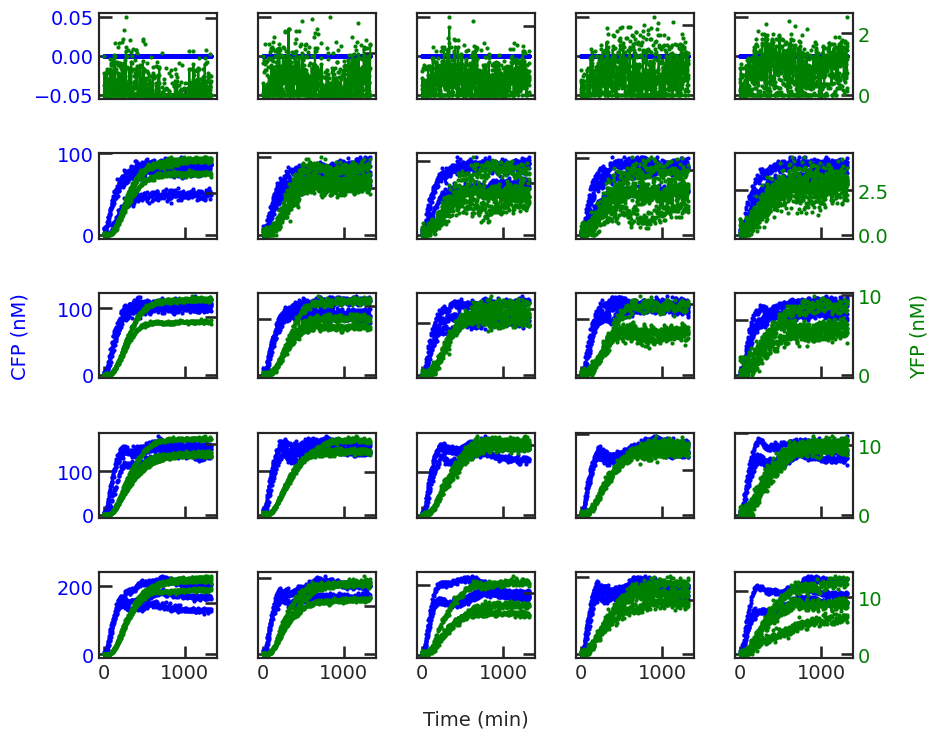

In [3]:
figsize = (10,8)
figc = plt.figure(figsize=figsize)

current_index = 1


cfp_median = np.zeros((num_timepoints,num_integrase_conditions,num_xis_conditions))
mScar_median = np.zeros((num_timepoints,num_integrase_conditions,num_xis_conditions))
yfp_median = np.zeros((num_timepoints,num_integrase_conditions,num_xis_conditions))

for int_ind in range(num_integrase_conditions):
    for xis_ind in range(num_xis_conditions):
        # cfp
        cfp_median[:,int_ind,xis_ind] = np.median(full_cfp[:,:,int_ind, xis_ind],axis=1)
        axc = figc.add_subplot(num_integrase_conditions,num_xis_conditions,current_index)
        axc.plot(timepoints,cfp_median[:,int_ind,xis_ind], 'b-')
        axc.plot(timepoints,full_cfp[:,:,int_ind,xis_ind], 'b.', markersize=4)
        for tl in axc.get_yticklabels():
            tl.set_color('b')
        # mScar
        mScar_median[:,int_ind,xis_ind] = np.median(full_mScar[:,:,int_ind, xis_ind],axis=1)
        # To include mScar plot, uncomment the following lines:
#         axc = figc.add_subplot(num_integrase_conditions,num_xis_conditions,current_index)
#         axc.plot(timepoints,mScar_median[:,int_ind,xis_ind], 'r-')
#         axc.plot(timepoints,full_mScar[:,:,int_ind,xis_ind], 'r.', markersize=4)
#         for tl in axc.get_yticklabels():
#             tl.set_color('r')
        # yfp
        axy = axc.twinx()
        yfp_median[:,int_ind,xis_ind] = np.median(full_yfp[:,:,int_ind, xis_ind],axis=1)
        axy.plot(timepoints, yfp_median[:,int_ind,xis_ind], 'g-')
        axy.plot(timepoints, full_yfp[:,:,int_ind,xis_ind], 'g.', markersize=4)
        for tl in axy.get_yticklabels():
            tl.set_color('g')
        if xis_ind > 0:
            axc.set_yticklabels([])
        if xis_ind < num_xis_conditions - 1:
            axy.set_yticklabels([])
        if int_ind < num_integrase_conditions - 1:
            axy.set_xticklabels([])
        
        if int_ind == num_integrase_conditions - 1 and xis_ind ==  num_xis_conditions//2:
            axc.set_xlabel('Time (min)',labelpad=20)
        if xis_ind == 0 and int_ind ==  num_integrase_conditions//2:
            axc.set_ylabel('CFP (nM)',color='b',labelpad=20)
        if xis_ind ==  num_xis_conditions - 1 and int_ind ==  num_integrase_conditions//2:
            axy.set_ylabel('YFP (nM)', color='g',labelpad=20)
        current_index += 1

figc.tight_layout()

In [4]:
initial_conditions = []
all_data = []
expdata_dict = {}
for int_ind, int_nm in zip(range(num_integrase_conditions), int_conditions):
    for xis_ind, xis_nm in zip(range(num_xis_conditions),xis_conditions):
        initial_conditions.append({"G_I": int_nm, "G_E":xis_nm, "G_tot": rep_nm})
        expdata_dict[(int_nm,xis_nm,'CFP')] = cfp_median[:,int_ind,xis_ind]
        expdata_dict[(int_nm,xis_nm,'mScar')] = mScar_median[:,int_ind,xis_ind]
        expdata_dict[(int_nm,xis_nm,'YFP')] = yfp_median[:,int_ind,xis_ind]
        all_data.append(expdata_dict)

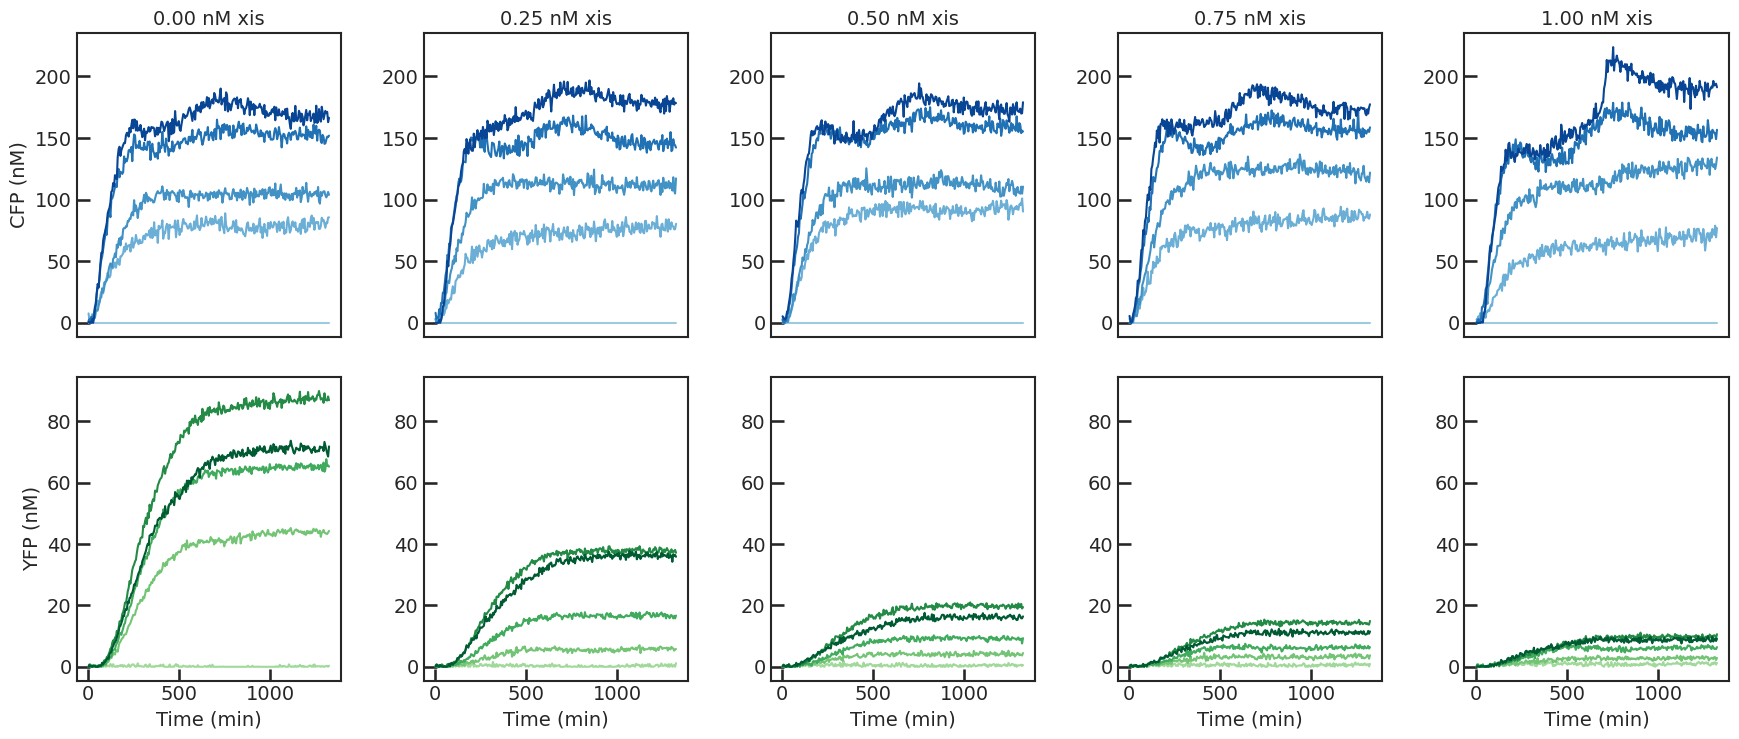

In [5]:
import numpy as np
import matplotlib.pyplot as plt
colorc = ['#9ecae1','#6baed6','#4292c6', '#2171b5','#084594']
colory = ['#a1d99b','#74c476','#41ab5d','#238b45','#005a32']
time_lim = (0,timepoints[-1]+1)
figsize = (18,8)
fig = plt.figure(figsize=figsize)
index = 1
for xis_ind in range(num_xis_conditions):
    if index == 1:
        axc = fig.add_subplot(2,num_integrase_conditions,index)
        axy = fig.add_subplot(2,num_xis_conditions,index+5)
    else:
        axc = fig.add_subplot(2,num_integrase_conditions,index, sharey = axc)
        axy = fig.add_subplot(2,num_xis_conditions,index+5, sharey = axy)
    
    for int_ind in range(num_integrase_conditions):
        axc.plot(timepoints, expdata_dict[(int_conditions[int_ind] ,xis_conditions[xis_ind],'CFP')],
                 color=colorc[int_ind] )
        axy.plot(timepoints, expdata_dict[(int_conditions[int_ind] ,xis_conditions[xis_ind],'YFP')]
                 ,color=colory[int_ind])
    
    axc.set_title('%1.2f nM xis' % (xis_conditions[xis_ind]))
    axy.set_xlabel('Time (min)')
    
    if index == 1:
        axc.set_ylabel('CFP (nM)')
        axy.set_ylabel('YFP (nM)')
    axc.set_xticks([])

    index += 1

fig.tight_layout()
# fig.savefig('../outputs/xis-raw-data.svg')

## Truncate data to 600 minutes:

We truncate the experimental data to 600 minutes as that is the time-period of interest and our model does not capture the leveling out of the fluorescence reporter amounts.

In [6]:
real_timepoints[:50][-1]

248.91666666666669

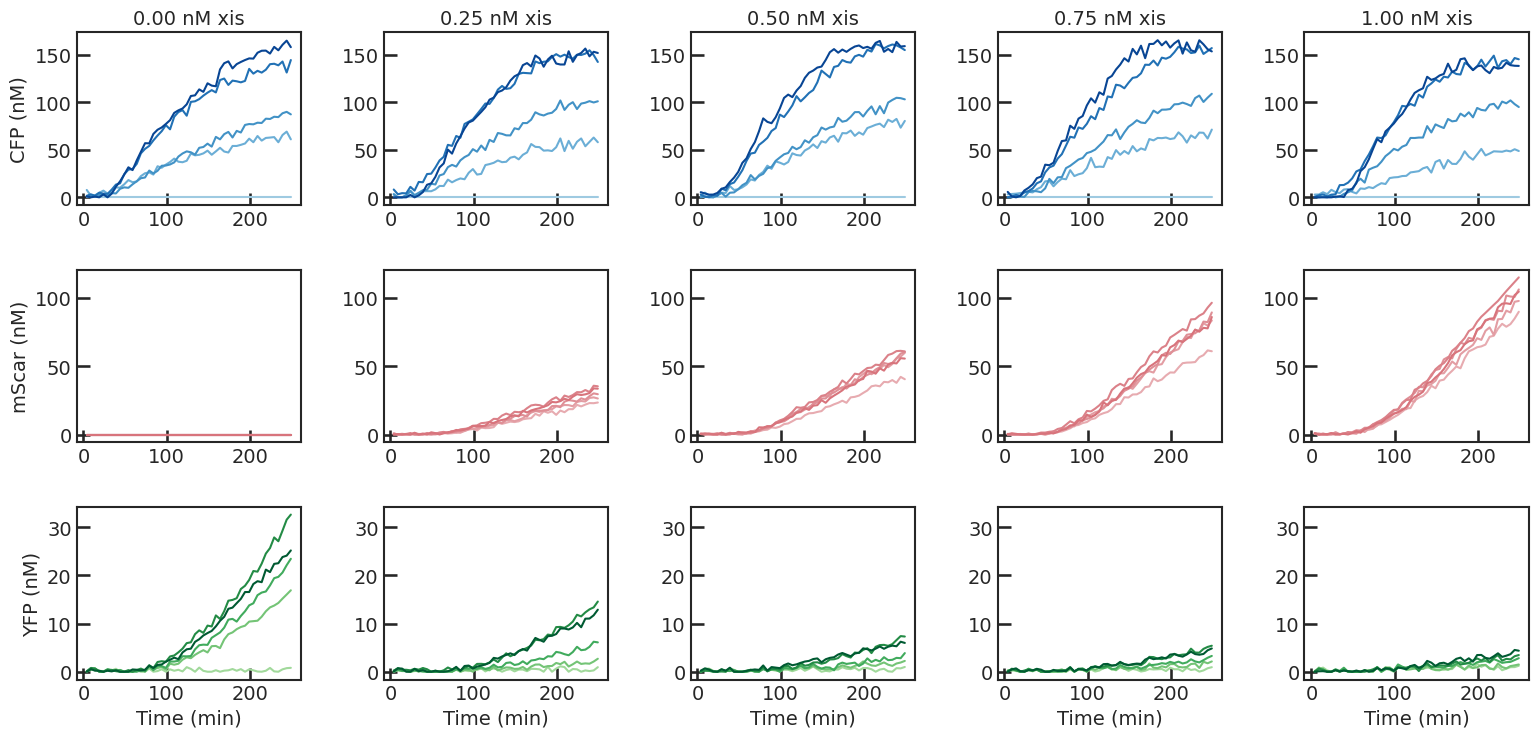

In [7]:
initial_conditions = []
all_data = []
expdata_dict = {}
truncate_to = 50
timepoints = real_timepoints[:truncate_to]
for int_ind, int_nm in zip(range(num_integrase_conditions),int_conditions):
    for xis_ind, xis_nm in zip(range(num_xis_conditions),xis_conditions):
        initial_conditions.append({"G_I": int_nm, "G_E":xis_nm, "G_tot": rep_nm})
        expdata_dict[(int_nm,xis_nm,'CFP')] = cfp_median[:truncate_to,int_ind,xis_ind]
        expdata_dict[(int_nm,xis_nm,'mScar')] = mScar_median[:truncate_to,int_ind,xis_ind]
        expdata_dict[(int_nm,xis_nm,'YFP')] = yfp_median[:truncate_to,int_ind,xis_ind]
        all_data.append(expdata_dict)

colorc = ['#9ecae1','#6baed6','#4292c6', '#2171b5','#084594']
colorm = ['#e7abb0','#e39da3','#df8f96','#db8189','#d8747c']
colory = ['#a1d99b','#74c476','#41ab5d','#238b45','#005a32']
plt.close()
figsize = (16,8)
fig = plt.figure(figsize=figsize)
index = 1
for xis_ind in range(num_xis_conditions):
    if index == 1:
        axc = fig.add_subplot(3,num_integrase_conditions,index)
        axm = fig.add_subplot(3,num_integrase_conditions,index+5)
        axy = fig.add_subplot(3,num_xis_conditions,index+10)
    else:
        axc = fig.add_subplot(3,num_integrase_conditions,index, sharey = axc)
        axm = fig.add_subplot(3,num_integrase_conditions,index+5, sharey = axm)
        axy = fig.add_subplot(3,num_xis_conditions,index+10, sharey = axy)
        
    for int_ind in range(num_integrase_conditions):
        axc.plot(timepoints, expdata_dict[(int_conditions[int_ind],xis_conditions[xis_ind],'CFP')],
                 color=colorc[int_ind] )
        axm.plot(timepoints, expdata_dict[(int_conditions[int_ind],xis_conditions[xis_ind],'mScar')],
                 color=colorm[int_ind] )
        axy.plot(timepoints, expdata_dict[(int_conditions[int_ind],xis_conditions[xis_ind],'YFP')],
                 color=colory[int_ind])
    
    axc.set_title('%1.2f nM xis' % (xis_conditions[xis_ind]))

    axy.set_xlabel('Time (min)')
    
    if index == 1:
        axc.set_ylabel('CFP (nM)')
        axm.set_ylabel('mScar (nM)')
        axy.set_ylabel('YFP (nM)')

    index += 1

fig.tight_layout()
# fig.savefig('../outputs/xis-data-full.svg')

# Run bioscrape inference

To identify parameter distributions, we run bioscrape inference for the example above. The three main ingredients of this black-box parameter inference pipeline are:

1. Experimental data as a `Pandas` dataframe (or a list of Dataframes) consisting of the measurements as columns along with a "time" column.
2. An SBML file that models the system we want to identify.
3. Prior information about parameters. 

We already have the experimental data as a list of Pandas dataframe above corresponding to a list of initial conditions. So, for the second step, we load the SBML file of the reduced model below:

In [8]:
from bioscrape.inference import py_inference
from bioscrape.types import Model
from bioscrape.simulator import *
import numpy as np
import pickle
import time


m = Model(sbml_filename = '../sbml_files/int-xis-minimal.xml')
csim = ModelCSimInterface(m)
c_ind = m.get_species_index('Int')
m_ind = m.get_species_index('Exc')
y_ind = m.get_species_index('YFP')

# timepoints = np.linspace(0,time_lim[1],601)
csim.py_prep_deterministic_simulation()

propagator = DeterministicSimulator()

simdata = {}
m.set_params({'a_e2': 0.05,'a_i': 0.3,'a_r': 1.0,'a_r1': 0.02,'a_r2': 0.02,
              'a_s1': 0.02,'d_e2': 0.02,'d_i': 500.0,'d_r': 0.001,'d_r1': 0.0007,
              'd_r2': 0.01,'d_s1': 10.0,'k': 0.01,'k_e': 0.3,'k_exc': 0.05,
              'k_i': 0.2,'k_int': 0.5})
for int_nm in int_conditions:
    for xis_nm in xis_conditions:
        m.set_species({"G_I": int_nm, "G_E":xis_nm, "G_tot": rep_nm})
        deterministic = propagator.py_simulate(csim, timepoints)
        simdata[(int_nm,xis_nm,'cfp')] = deterministic.py_get_result()[:,c_ind]
        simdata[(int_nm,xis_nm,'mScar')] = deterministic.py_get_result()[:,m_ind]
        simdata[(int_nm,xis_nm,'yfp')] = deterministic.py_get_result()[:,y_ind]

line 1: (00002 [Error]) File unreadable.




SyntaxError: SBML File ../sbml_files/int-xis-minimal.xml cannot be read without errors (<string>)

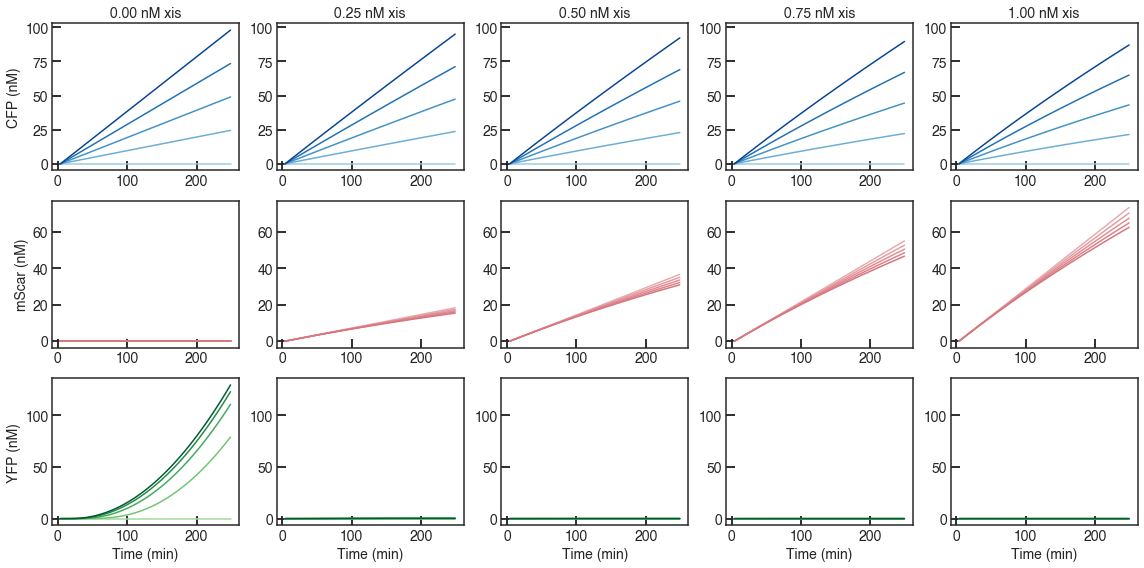

In [334]:
colorc = ['#9ecae1','#6baed6','#4292c6', '#2171b5','#084594']
colorm = ['#e7abb0','#e39da3','#df8f96','#db8189','#d8747c']
colory = ['#a1d99b','#74c476','#41ab5d','#238b45','#005a32']
plt.close()
figsize = (16,8)
fig = plt.figure(figsize=figsize)
index = 1
for xis_ind in range(num_xis_conditions):
    if index == 1:
        axc = fig.add_subplot(3,num_integrase_conditions,index)
        axm = fig.add_subplot(3,num_integrase_conditions,index+5)
        axy = fig.add_subplot(3,num_xis_conditions,index+10)
    else:
        axc = fig.add_subplot(3,num_integrase_conditions,index, sharey = axc)
        axm = fig.add_subplot(3,num_integrase_conditions,index+5, sharey = axm)
        axy = fig.add_subplot(3,num_xis_conditions,index+10, sharey = axy)
        
    for int_ind in range(num_integrase_conditions):
        axc.plot(timepoints, simdata[(int_conditions[int_ind],xis_conditions[xis_ind],'cfp')],
                 color=colorc[int_ind] )
        axm.plot(timepoints, simdata[(int_conditions[int_ind],xis_conditions[xis_ind],'mScar')],
                 color=colorm[int_ind] )
        axy.plot(timepoints, simdata[(int_conditions[int_ind],xis_conditions[xis_ind],'yfp')],
                 color=colory[int_ind])
    
    axc.set_title('%1.2f nM xis' % (xis_conditions[xis_ind]))

    axy.set_xlabel('Time (min)')
    
    if index == 1:
        axc.set_ylabel('CFP (nM)')
        axm.set_ylabel('mScar (nM)')
        axy.set_ylabel('YFP (nM)')

    index += 1

fig.tight_layout()


In [335]:
# Create a data frame with all the simulated and real results to use here
# as the source for doing parameter inference on the data (simulated or real)
# Columns are string for real or simulated, time, cfp, yfp, int_nm, rep_nm

import pandas as pd
e_df = {'type':[], 'time':[], 'int_nm':[], 'rep_nm':[], 'xis_nm':[], 'Int':[], 'Exc':[], 'YFP':[]}

# add the simulated data
for int_ind, int_nm in zip(range(num_integrase_conditions), int_conditions):
    for xis_ind, xis_nm in zip(range(num_xis_conditions),xis_conditions):
#         timepoints = np.linspace(0,time_lim[1],241)
        length = len(timepoints)
        e_df['time'].extend(timepoints)
        e_df['type'].extend(['sim']*length)
        e_df['int_nm'].extend([int_nm]*length)
        e_df['xis_nm'].extend([xis_nm]*length)
        e_df['rep_nm'].extend([rep_nm]*length)
        e_df['Int'].extend(simdata[(int_nm,xis_nm,'cfp')])
        e_df['Exc'].extend(simdata[(int_nm,xis_nm,'mScar')])
        e_df['YFP'].extend(simdata[(int_nm,xis_nm,'yfp')])

# add the real data
for int_ind, int_nm in zip(range(num_integrase_conditions), int_conditions):
    for xis_ind, xis_nm in zip(range(num_xis_conditions),xis_conditions):
#         timepoints = real_timepoints[:49]
        length = len(timepoints)
        e_df['time'].extend(timepoints)
        e_df['type'].extend(['exp']*length)
        e_df['int_nm'].extend([int_nm]*length)
        e_df['xis_nm'].extend([xis_nm]*length)
        e_df['rep_nm'].extend([rep_nm]*length)
        e_df['Int'].extend(expdata_dict[(int_nm,xis_nm,'CFP')])
        e_df['Exc'].extend(expdata_dict[(int_nm,xis_nm,'mScar')])
        e_df['YFP'].extend(expdata_dict[(int_nm,xis_nm,'YFP')])

e_df = pd.DataFrame(e_df)

data_file = open('trace_data_frame_xis.b','wb')
pickle.dump(e_df, data_file)
data_file.close()

In [336]:
initial_conditions = []
all_data = []
int_levels = [0, 0.5, 1, 1.5]
xis_levels = [0, 0.25, 0.5, 0.75, 1]
for int_nm in int_levels:
    for xis_nm in xis_levels:
        initial_conditions.append({"G_I": int_nm, "G_E":xis_nm, "G_tot": rep_nm})
        exp_data = e_df.loc[(e_df['int_nm'].eq(int_nm)) & (e_df['xis_nm'].eq(xis_nm))\
                            & (e_df['rep_nm'].eq(rep_nm)) & (e_df['type'] == 'exp')]
        all_data.append(exp_data)

In [337]:
# m.set_params({'k_i': 0.24, 'k_int': 0.05, 'K_I': 3335.0, 'n': 1.0, 'k': 0.05})

In [338]:
m.get_parameter_dictionary()

{'a_e2': 0.05,
 'a_i': 0.3,
 'a_r': 1.0,
 'a_r1': 0.02,
 'a_r2': 0.02,
 'a_s1': 0.02,
 'd_e2': 0.02,
 'd_i': 500.0,
 'd_r': 0.001,
 'd_r1': 0.0007,
 'd_r2': 0.01,
 'd_s1': 10.0,
 'k': 0.01,
 'k_e': 0.3,
 'k_exc': 0.05,
 'k_i': 0.2,
 'k_int': 0.5}

In [339]:
initial_conditions

[{'G_I': 0, 'G_E': 0, 'G_tot': 1},
 {'G_I': 0, 'G_E': 0.25, 'G_tot': 1},
 {'G_I': 0, 'G_E': 0.5, 'G_tot': 1},
 {'G_I': 0, 'G_E': 0.75, 'G_tot': 1},
 {'G_I': 0, 'G_E': 1, 'G_tot': 1},
 {'G_I': 0.5, 'G_E': 0, 'G_tot': 1},
 {'G_I': 0.5, 'G_E': 0.25, 'G_tot': 1},
 {'G_I': 0.5, 'G_E': 0.5, 'G_tot': 1},
 {'G_I': 0.5, 'G_E': 0.75, 'G_tot': 1},
 {'G_I': 0.5, 'G_E': 1, 'G_tot': 1},
 {'G_I': 1, 'G_E': 0, 'G_tot': 1},
 {'G_I': 1, 'G_E': 0.25, 'G_tot': 1},
 {'G_I': 1, 'G_E': 0.5, 'G_tot': 1},
 {'G_I': 1, 'G_E': 0.75, 'G_tot': 1},
 {'G_I': 1, 'G_E': 1, 'G_tot': 1},
 {'G_I': 1.5, 'G_E': 0, 'G_tot': 1},
 {'G_I': 1.5, 'G_E': 0.25, 'G_tot': 1},
 {'G_I': 1.5, 'G_E': 0.5, 'G_tot': 1},
 {'G_I': 1.5, 'G_E': 0.75, 'G_tot': 1},
 {'G_I': 1.5, 'G_E': 1, 'G_tot': 1}]

In [340]:
len(all_data)

20

In [341]:
m.get_species_dictionary()

{'G_I': 2.0,
 'Int': 0.0,
 'A': 0.0,
 'Exc': 0.0,
 'C_IE': 0.0,
 'G_E': 1.0,
 'YFP': 0.0,
 'G_tot': 1.0}

## Run parameter inference (step 1):


creating an ensemble sampler with threads= 1


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:12:52<00:00,  4.37s/it]


results written to mcmc_results.csv
Successfully completed MCMC parameter identification procedure. Check the MCMC diagnostics to evaluate convergence.
Parameter posterior distribution convergence plots:


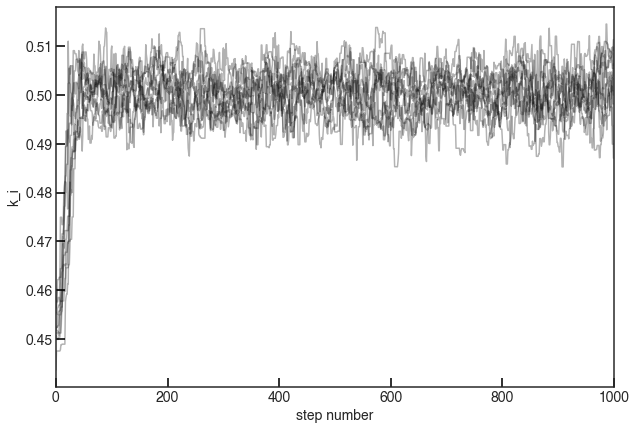

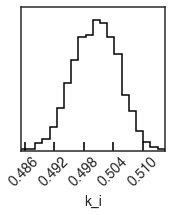

In [342]:
from bioscrape.inference import py_inference

init_values = np.array([0.45])

prior = {'k_i' : ['gaussian', 0.45, 5, 'positive']}

nwalkers = 10
nsteps = 1000
sampler, pid = py_inference(Model = m, exp_data = all_data, measurements = ['Int'], time_column = ['time'],
                            nwalkers = nwalkers, nsteps = nsteps, sim_type = 'deterministic', 
                            initial_conditions = initial_conditions, 
                            init_seed = init_values,
                            params_to_estimate = [p for p in prior],
                            prior = prior, convergence_check = False, debug = False)

In [343]:
sampler_ki = sampler

In [344]:
pid_ki = pid

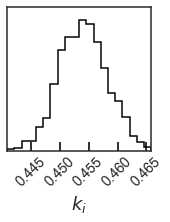

In [242]:
import corner
labels = ['$k_{i}$']
flat_samples = sampler.get_chain(discard=int(.2*nsteps), thin = int(0.5*nwalkers), flat=True)
fig = corner.corner(flat_samples, levels = (0.75,), 
                    labels = labels, use_math_text = False, 
                    label_kwargs = {'fontsize':18})
fig.savefig('outputs/mcmc_cfp_corner-xis.svg')

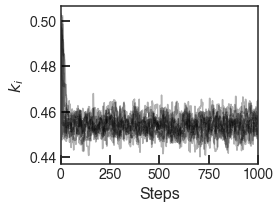

In [243]:
fig, ax = plt.subplots(figsize = (4,3))
samples = sampler.get_chain()[:,:,0]
ax.plot(samples, alpha = 0.3, color = 'k')
# ax.set_xlim(0, len(samples))
ax.set_xlabel('Steps', fontsize = 16)
ax.set_ylabel('$k_i$', fontsize = 16)
ax.set_xlim([0,nsteps])
fig.tight_layout()
fig.savefig('outputs/mcmc_cfp_chain-xis.svg')

In [345]:
k_i = pid.cost_params[np.where(pid.cost_progress == np.max(pid.cost_progress))[0][0]][0]

In [346]:
k_i

0.5002088618372582

## Bioscrape Inference Step 2: Identify Xis-mScarlet parameters

In [347]:
m = Model(sbml_filename = 'sbml_files/int-xis-minimal.xml')

C:\Users\apand\AppData\Local\Continuum\anaconda3\lib\site-packages\bioscrape\sbmlutil.py:56: UserWarning: Compartments, UnitDefintions, Events, and some other SBML model components are not recognized by bioscrape. Refer to the bioscrape wiki for more information.
  warnings.warn('Compartments, UnitDefintions, Events, and some other SBML model components are not recognized by bioscrape. ' +


In [348]:
# m.set_parameter('k_i', k_i[0])
m.set_parameter('k_i', k_i)

In [349]:
m.get_parameter_dictionary()

{'a_e2': 0.05,
 'a_i': 0.3,
 'a_r': 1.0,
 'a_r1': 0.02,
 'a_r2': 0.02,
 'a_s1': 0.02,
 'd_e2': 0.02,
 'd_i': 500.0,
 'd_r': 0.001,
 'd_r1': 0.0007,
 'd_r2': 0.01,
 'd_s1': 10.0,
 'k': 10.0,
 'k_e': 0.3,
 'k_exc': 0.05,
 'k_i': 0.5002088618372582,
 'k_int': 0.5}

In [350]:
m.get_species_dictionary()

{'G_I': 1.0,
 'Int': 0.0,
 'A': 0.0,
 'Exc': 0.0,
 'C_IE': 0.0,
 'G_E': 0.5,
 'YFP': 0.0,
 'G_tot': 0.0}

In [351]:
initial_conditions

[{'G_I': 0, 'G_E': 0, 'G_tot': 1},
 {'G_I': 0, 'G_E': 0.25, 'G_tot': 1},
 {'G_I': 0, 'G_E': 0.5, 'G_tot': 1},
 {'G_I': 0, 'G_E': 0.75, 'G_tot': 1},
 {'G_I': 0, 'G_E': 1, 'G_tot': 1},
 {'G_I': 0.5, 'G_E': 0, 'G_tot': 1},
 {'G_I': 0.5, 'G_E': 0.25, 'G_tot': 1},
 {'G_I': 0.5, 'G_E': 0.5, 'G_tot': 1},
 {'G_I': 0.5, 'G_E': 0.75, 'G_tot': 1},
 {'G_I': 0.5, 'G_E': 1, 'G_tot': 1},
 {'G_I': 1, 'G_E': 0, 'G_tot': 1},
 {'G_I': 1, 'G_E': 0.25, 'G_tot': 1},
 {'G_I': 1, 'G_E': 0.5, 'G_tot': 1},
 {'G_I': 1, 'G_E': 0.75, 'G_tot': 1},
 {'G_I': 1, 'G_E': 1, 'G_tot': 1},
 {'G_I': 1.5, 'G_E': 0, 'G_tot': 1},
 {'G_I': 1.5, 'G_E': 0.25, 'G_tot': 1},
 {'G_I': 1.5, 'G_E': 0.5, 'G_tot': 1},
 {'G_I': 1.5, 'G_E': 0.75, 'G_tot': 1},
 {'G_I': 1.5, 'G_E': 1, 'G_tot': 1}]

creating an ensemble sampler with threads= 1


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:05:06<00:00,  3.91s/it]


results written to mcmc_results.csv
Successfully completed MCMC parameter identification procedure. Check the MCMC diagnostics to evaluate convergence.
Parameter posterior distribution convergence plots:


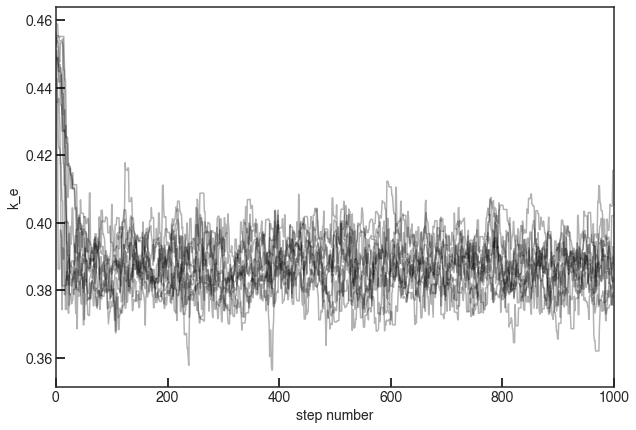

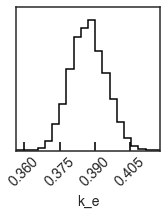

In [352]:
from bioscrape.inference import py_inference

init_values = np.array([0.45])

prior = {'k_e' : ['gaussian', 0.45, 5, 'positive']}
nwalkers = 10
nsteps = 1000
sampler, pid = py_inference(Model = m, exp_data = all_data, measurements = ['Exc'], time_column = ['time'],
                            nwalkers = nwalkers, nsteps = nsteps, sim_type = 'deterministic', 
                            initial_conditions = initial_conditions, 
                            init_seed = init_values,
                            params_to_estimate = [p for p in prior],
                            prior = prior, convergence_check = False, debug = False)
# pid = py_inference(Model = m, exp_data = all_data, measurements = ['Int'], time_column = ['time'],
#                     nwalkers = nwalkers, nsteps = nsteps, sim_type = 'deterministic', 
#                     initial_conditions = initial_conditions, 
#                     init_seed = init_values,
#                     params_to_estimate = [p for p in prior],
#                     prior = prior, inference_type = "lmfit")

In [353]:
sampler_ke = sampler

In [354]:
pid_ke = pid

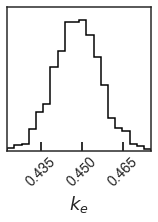

In [252]:
import corner
labels = ['$k_{e}$']
flat_samples = sampler.get_chain(discard=int(.2*nsteps), thin = int(0.5*nwalkers), flat=True)
fig = corner.corner(flat_samples, levels = (0.75,), 
                    labels = labels, use_math_text = False, 
                    label_kwargs = {'fontsize':18})
fig.savefig('outputs/mcmc_mScar_corner-xis.svg')

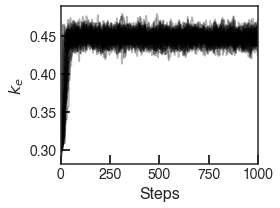

In [253]:
fig, ax = plt.subplots(figsize = (4,3))
samples = sampler.get_chain()[:,:,0]
ax.plot(samples, alpha = 0.3, color = 'k')
# ax.set_xlim(0, len(samples))
ax.set_xlabel('Steps', fontsize = 16)
ax.set_ylabel('$k_e$', fontsize = 16)
ax.set_xlim([0,nsteps])
fig.tight_layout()
fig.savefig('outputs/mcmc_mScar_chain-xis.svg')

In [355]:
k_e = pid.cost_params[np.where(pid.cost_progress == np.max(pid.cost_progress))[0][0]][0]

In [356]:
k_e

0.3869390062543355

## Bioscrape inference step 3: YFP

In [357]:
m = Model(sbml_filename = 'sbml_files/int-xis-minimal.xml')

C:\Users\apand\AppData\Local\Continuum\anaconda3\lib\site-packages\bioscrape\sbmlutil.py:56: UserWarning: Compartments, UnitDefintions, Events, and some other SBML model components are not recognized by bioscrape. Refer to the bioscrape wiki for more information.
  warnings.warn('Compartments, UnitDefintions, Events, and some other SBML model components are not recognized by bioscrape. ' +


In [358]:
m.set_params({'k_i': k_i, 'k_e': k_e})

In [359]:
m.get_parameter_dictionary()

{'a_e2': 0.05,
 'a_i': 0.3,
 'a_r': 1.0,
 'a_r1': 0.02,
 'a_r2': 0.02,
 'a_s1': 0.02,
 'd_e2': 0.02,
 'd_i': 500.0,
 'd_r': 0.001,
 'd_r1': 0.0007,
 'd_r2': 0.01,
 'd_s1': 10.0,
 'k': 10.0,
 'k_e': 0.3869390062543355,
 'k_exc': 0.05,
 'k_i': 0.5002088618372582,
 'k_int': 0.5}

creating an ensemble sampler with threads= 1


C:\Users\apand\AppData\Local\Continuum\anaconda3\lib\site-packages\emcee\ensemble.py:258: RuntimeWarning: Initial state is not linearly independent and it will not allow a full exploration of parameter space
  category=RuntimeWarning,
  0%|                                                                            | 16/20000 [01:16<26:54:58,  4.85s/it]C:\Users\apand\AppData\Roaming\Python\Python37\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
 35%|████████████████████████▌                                              | 6926/20000 [10:12:12<24:03:07,  6.62s/it]C:\Users\apand\AppData\Roaming\Python\Python37\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
ode

results written to mcmc_results.csv
Successfully completed MCMC parameter identification procedure. Check the MCMC diagnostics to evaluate convergence.
Parameter posterior distribution convergence plots:


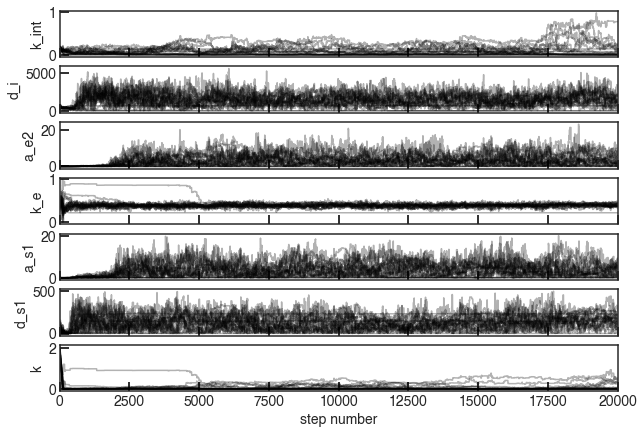

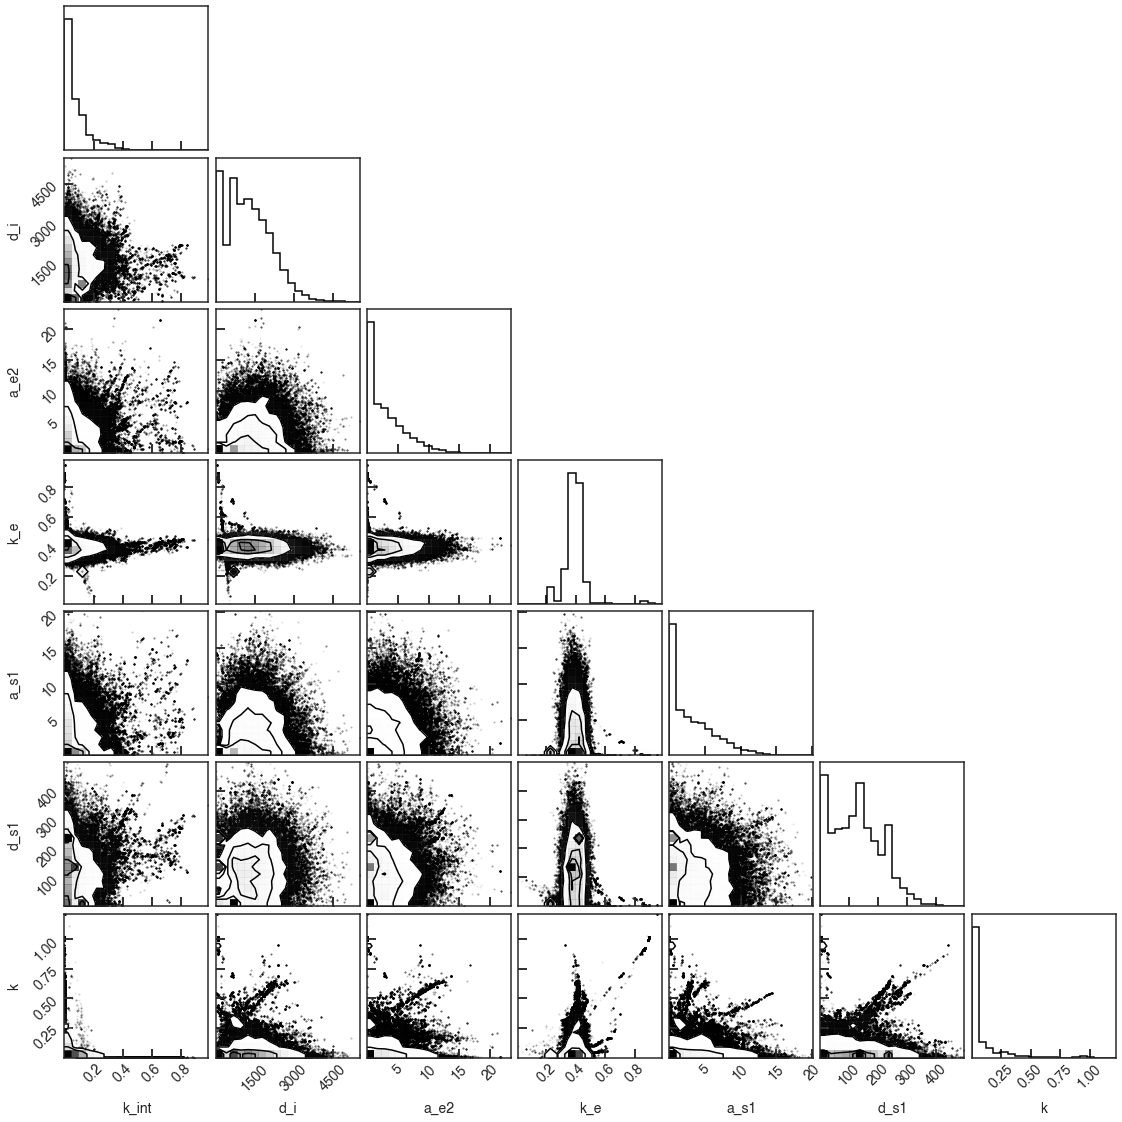

In [360]:
from bioscrape.inference import py_inference

init_values = np.array([0.2, 500, 0.02, k_e, 0.1, 100, 2])

prior = {'k_int' : ['gaussian', 0.2, 5, 'positive'], 'd_i':['gaussian', 500, 1e3, 'positive'],
         'a_e2':['gaussian', 0.02, 5, 'positive'], 'k_e':['gaussian', k_e, 0.1*k_e, 'positive'],
         'a_s1' : ['gaussian', 0.1, 5, 'positive'], 'd_s1' : ['gaussian', 100, 100, 'positive'],
         'k' : ['gaussian', 2, 10, 'positive']}
nwalkers = 20
nsteps = 20000
sampler, pid = py_inference(Model = m, exp_data = all_data, measurements = ['YFP'], time_column = ['time'],
                            nwalkers = nwalkers, nsteps = nsteps, sim_type = 'deterministic', 
                            initial_conditions = initial_conditions, 
                            init_seed = init_values,
                            params_to_estimate = [p for p in prior],
                            prior = prior, convergence_check = False, debug = False)
# pid = py_inference(Model = m, exp_data = all_data, measurements = ['Int'], time_column = ['time'],
#                     nwalkers = nwalkers, nsteps = nsteps, sim_type = 'deterministic', 
#                     initial_conditions = initial_conditions, 
#                     init_seed = init_values,
#                     params_to_estimate = [p for p in prior],
#                     prior = prior, inference_type = "lmfit")

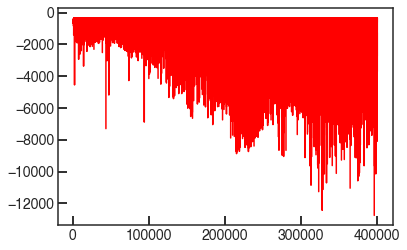

In [62]:
plt.plot(pid.cost_progress)

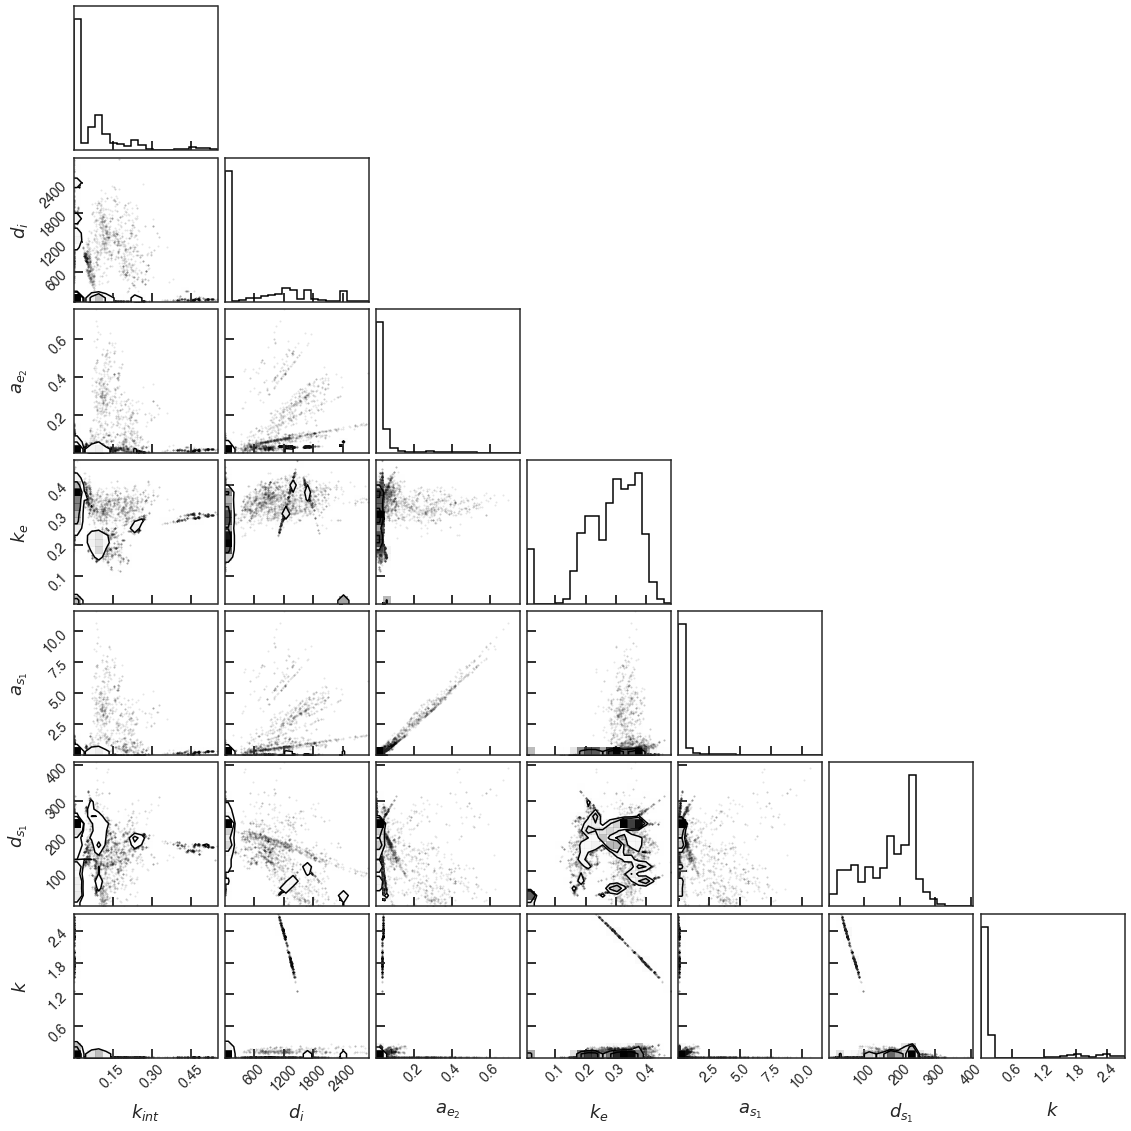

In [315]:
import corner
labels = ['$k_{int}$', '$d_i$', '$a_{e_2}$', '$k_e$','$a_{s_1}$', '$d_{s_1}$', '$k$']
flat_samples = sampler.get_chain(discard=int(.5*nsteps), thin = int(0.5*nwalkers), flat=True)
fig = corner.corner(flat_samples, levels = (0.5, 0.75,), 
                    labels = labels, use_math_text = False, 
                    label_kwargs = {'fontsize':18})
# fig.savefig('outputs/mcmc_yfp_corner-xis.svg')

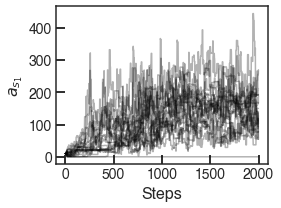

In [195]:
fig, ax = plt.subplots(figsize = (4,3))
samples = sampler.get_chain()[:,:,2]
ax.plot(samples, alpha = 0.3, color = 'k')
# ax.set_xlim(0, len(samples))
ax.set_xlabel('Steps', fontsize = 16)
ax.set_ylabel('$a_{s_1}$', fontsize = 16)
# ax.set_xlim([0,nsteps])
fig.tight_layout()
# fig.savefig('outputs/mcmc_yfp_chain_k-xis.svg')

Text(0.5, 1.0, 'Cost Progress')

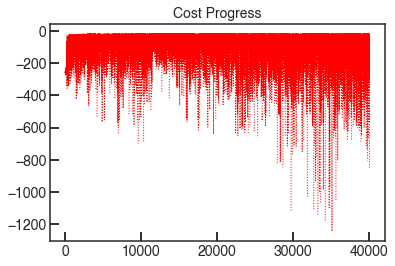

In [196]:
plt.plot(pid.cost_progress, 'r', ls = 'dotted', lw = 1)
plt.title('Cost Progress')

In [321]:
np.max(pid.cost_progress)

-367.5080969897264

In [320]:
 min_cost_params = pid.cost_params[np.where(pid.cost_progress == np.max(pid.cost_progress))[0][0]]

## Model simulation with data

In [262]:
m.get_parameter_dictionary()

{'a_e2': 0.05,
 'a_i': 0.3,
 'a_r': 1.0,
 'a_r1': 0.02,
 'a_r2': 0.02,
 'a_s1': 0.16146801725817525,
 'd_e2': 0.02,
 'd_i': 500.0,
 'd_r': 0.001,
 'd_r1': 0.0007,
 'd_r2': 0.01,
 'd_s1': 128.0609250574168,
 'k': 2.957032512885519,
 'k_e': 0.4481164750192213,
 'k_exc': 0.05,
 'k_i': 0.4541684235672338,
 'k_int': 0.0004349896360900262}

In [ ]:
flat_samples[2129]

In [167]:
np.shape(fc)

(48000, 5)

In [322]:
# Generate a dataframe with simulated trajectories from the MCMC results
# chain = pickle.load(open('data/mcmc/exp_sigma_2.0.b','rb'))
# fc = np.exp(chain[:,-1,:])
# fc = chain[:,-1,:]
fc = sampler.get_chain(discard=int(0.3*nsteps), thin=int(0.5*nwalkers), flat = True)
df = {}
df['param_index'] = []
df['Int'] = []
df['Exc'] = []
df['YFP'] = []
df['time'] = []
df['xis_nm'] = []
df['rep_nm'] = []
df['int_nm'] = []

# Perform simulations
num_iterations = 5
param_indices = np.random.permutation(np.arange(fc.shape[0]))[:num_iterations]
for param_index in param_indices:
    for xis_nm in xis_levels:
        for int_nm in int_levels:  
            m = Model(sbml_filename = 'int-xis-minimal.xml')
            csim = ModelCSimInterface(m)
            c_ind = m.get_species_index('Int')
            m_ind = m.get_species_index('Exc')
            y_ind = m.get_species_index('YFP')

#             timepoints = np.linspace(0,time_lim[1],241)
            timepoints = pid.timepoints[0]
            csim.py_prep_deterministic_simulation()

            propagator = DeterministicSimulator()
            m.set_species({"G_I": int_nm, "G_E":xis_nm, "G_tot": rep_nm})
            params = fc[param_index,:]
#             m.set_params({'k_i':params[0]})
            m.set_params({'k_i':k_i,'k_e':k_e})
#             m.set_params({'k_int':params[0], 'd_i':params[1], 'a_e2':params[2],
#                           'k_e':params[3], 'a_s1':params[4], 'd_s1':params[5], 'k': params[6]})
            m.set_params({'k_int':min_cost_params[0], 'd_i':min_cost_params[1], 'a_e2':min_cost_params[2],
                          'k_e':min_cost_params[3], 'a_s1':min_cost_params[4], 'd_s1':min_cost_params[5],
                          'k': min_cost_params[6]})
            deterministic = propagator.py_simulate(csim, timepoints)
            
            df['param_index'].extend([param_index]*len(timepoints))
            df['Int'].extend(deterministic.py_get_result()[:,c_ind])
            df['Exc'].extend(deterministic.py_get_result()[:,m_ind])
            df['YFP'].extend(deterministic.py_get_result()[:,y_ind])
            df['time'].extend(timepoints)
            df['xis_nm'].extend([xis_nm]*len(timepoints))
            df['rep_nm'].extend([rep_nm]*len(timepoints))
            df['int_nm'].extend([int_nm]*len(timepoints))

simdf = pd.DataFrame(df)

C:\Users\apand\AppData\Local\Continuum\anaconda3\lib\site-packages\bioscrape\sbmlutil.py:56: UserWarning: Compartments, UnitDefintions, Events, and some other SBML model components are not recognized by bioscrape. Refer to the bioscrape wiki for more information.
  warnings.warn('Compartments, UnitDefintions, Events, and some other SBML model components are not recognized by bioscrape. ' +
C:\Users\apand\AppData\Roaming\Python\Python37\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


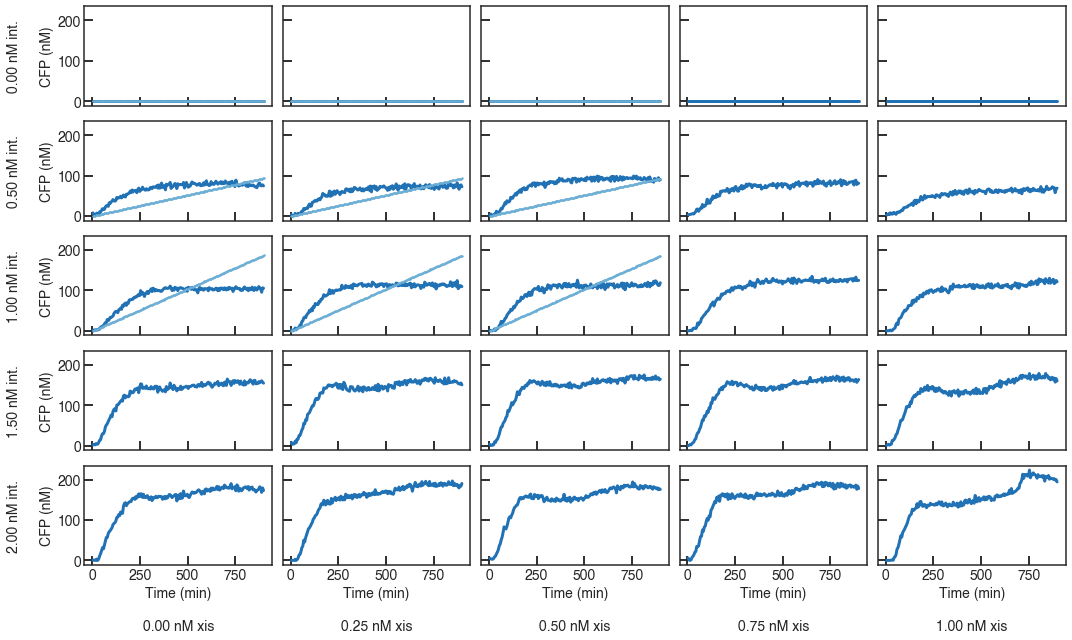

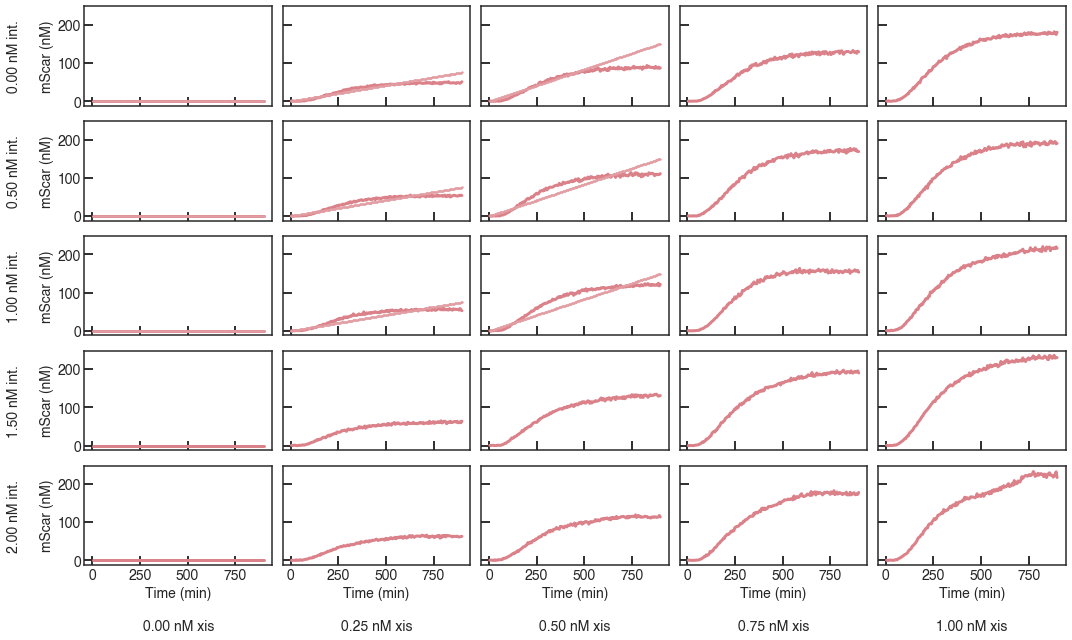

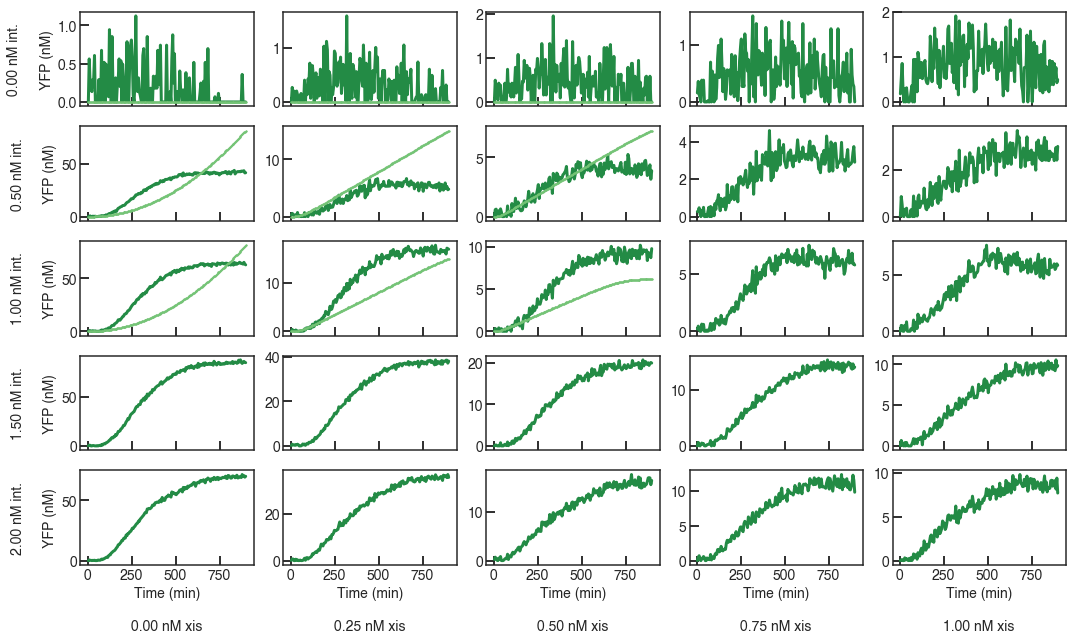

In [323]:
    colorc = ['#9ecae1','#6baed6','#4292c6', '#2171b5','#084594']
    colorm = ['#e7abb0','#e39da3','#df8f96','#db8189','#d8747c']
    colory = ['#a1d99b','#74c476','#41ab5d','#238b45','#005a32']

    infile = open('trace_data_frame_xis.b','rb')
    df = pickle.load(infile)
    infile.close()
    edf = df[df.type == 'exp']

    figsize = (15,9)
    fig, axes = plt.subplots(5,5,figsize=figsize, sharey = True)
    fig2, axes2 = plt.subplots(5,5,figsize=figsize, sharey = True)
    fig3, axes3 = plt.subplots(5,5,figsize=figsize)

    for int_ind, int_nm in zip(range(num_integrase_conditions), int_conditions):
        for xis_ind, xis_nm in zip(range(num_xis_conditions), xis_conditions):
            ax = axes[int_ind,xis_ind]
            ax2 = axes2[int_ind,xis_ind]
            ax3 = axes3[int_ind,xis_ind]
            etemp = edf[(edf.int_nm == int_nm) & (edf.xis_nm == xis_nm) & (edf.rep_nm == rep_nm)]

            ax.plot(etemp.time,etemp.Int,'-',linewidth=3, color=colorc[3])
            ax2.plot(etemp.time,etemp.Exc,'-',linewidth=3, color=colorm[3])
#             ax.set_xlim((0,180))
#             ax.set_ylim((0,200))

            ax3.plot(etemp.time,etemp.YFP,'-',linewidth=3,color=colory[3])
#             ax2.set_xlim((0,180))
#             ax2.set_ylim((0,60))

            stemp = simdf[(simdf.int_nm == int_nm) & (simdf.xis_nm == xis_nm) & (simdf.rep_nm == rep_nm)]
            ax.plot(stemp.time, stemp.Int, '.',color = colorc[1], markersize = 2, alpha= 0.5)
            ax2.plot(stemp.time, stemp.Exc, '.',color = colorm[1], markersize = 2, alpha= 0.5)
            ax3.plot(stemp.time, stemp.YFP, '.',color = colory[1], markersize = 2, alpha= 0.5)

            if int_ind == 4:
                ax.set_xlabel('Time (min)\n\n%.2f nM xis' % (xis_nm))
                ax2.set_xlabel('Time (min)\n\n%.2f nM xis' % (xis_nm))
                ax3.set_xlabel('Time (min)\n\n%.2f nM xis' % (xis_nm))
            else:
                ax.set_xticklabels([])
                ax2.set_xticklabels([])
                ax3.set_xticklabels([])
            if xis_ind == 0:
                ax.set_ylabel('%.2f nM int.\n\nCFP (nM)' % (int_nm))
                ax2.set_ylabel('%.2f nM int.\n\nmScar (nM)' % (int_nm))
                ax3.set_ylabel('%.2f nM int.\n\nYFP (nM)' % (int_nm))
#             else:
#                 ax.set_yticklabels([])
#                 ax2.set_yticklabels([])

    fig.tight_layout()
#     fig.savefig('outputs/model-data-cfp-xis.svg')
    fig2.tight_layout()
#     fig2.savefig('outputs/model-data-mScar-xis.svg')
    fig3.tight_layout()
#     fig3.savefig('outputs/model-data-yfp-xis.svg')


In [324]:
min_cost_params

array([1.46460166e-03, 3.88334391e-03, 2.21731753e-02, 3.36422525e-01,
       1.07983861e-02, 2.29157058e+02, 1.39452929e-01])